# Fraud Modeling with Light GBM

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import sys, os, time, warnings, pdb, pickle, random, math, re, json
warnings.filterwarnings('ignore')
sys.path.insert(0, '../scripts')

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

GLOBAL_SEED=42
np.set_printoptions(precision=4)
sns.set_style("darkgrid")
pd.set_option('display.float_format', '{:.2f}'.format)
%matplotlib inline

In [2]:
model_dir = Path('../models/gbm')

In [3]:
day_map = {k:v for k,v in zip(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])}

In [4]:
read_cols = ['name_enc', 'gender_enc', 'age_at_trans_norm', 'job_enc', 'cc_num_enc', 'merchant_enc', 'category_enc', 'merch_lat_norm', 'merch_long_norm', 'city_pop_norm', 'lat_norm', 'long_norm', 'day_of_week', 'week_of_year', 'month', 'amt', 'is_fraud']

## Load and Prepare Data

In [5]:
train_df = pd.read_csv('../data/processed_train.csv', usecols=read_cols)
val_df = pd.read_csv('../data/processed_val.csv', usecols=read_cols)
test_df = pd.read_csv('../data/processed_test.csv', usecols=read_cols)

In [6]:
features = [col for col in train_df.columns if col != 'is_fraud']

In [7]:
X_train, y_train = train_df[features], train_df['is_fraud']
X_val, y_val = val_df[features], val_df['is_fraud']
X_test, y_test = test_df[features], test_df['is_fraud']

In [8]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

## Model Training

In [ ]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'is_unbalance': True,
    # 'scale_pos_weight': np.sum(y_train == 0) / np.sum(y_train == 1)
}

In [ ]:
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=5),
    ]
)

In [ ]:
model.save_model(model_dir/'model.txt')

## Model Testing

In [10]:
model = lgb.Booster(model_file=model_dir/'model.txt')
y_pred = model.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred)
y_pred_score = model.predict(X_test)
y_pred = (y_pred_score > 0.5).astype(int)
auc = roc_auc_score(y_test, y_pred_score)

report = classification_report(y_test, y_pred)

print(f"AUC on test set: {auc:0.3f}")
print("\nClassification Report:")
print(report)

AUC on test set: 0.991

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    276936
           1       0.11      0.95      0.19       876

    accuracy                           0.97    277812
   macro avg       0.55      0.96      0.59    277812
weighted avg       1.00      0.97      0.98    277812



## Feature Importance

              feature  importance
0                 amt 66140406.76
1        category_enc 12583534.93
2   age_at_trans_norm  1479190.76
3       city_pop_norm   853726.82
4            name_enc   328601.64
5        week_of_year   268873.37
6        merchant_enc   246307.69
7           long_norm   188723.71
8      merch_lat_norm   152167.10
9          cc_num_enc   145369.25
10            job_enc   136954.23
11    merch_long_norm   129024.20
12           lat_norm    99115.61
13         gender_enc    92186.76
14        day_of_week    68689.99
15              month    40661.56


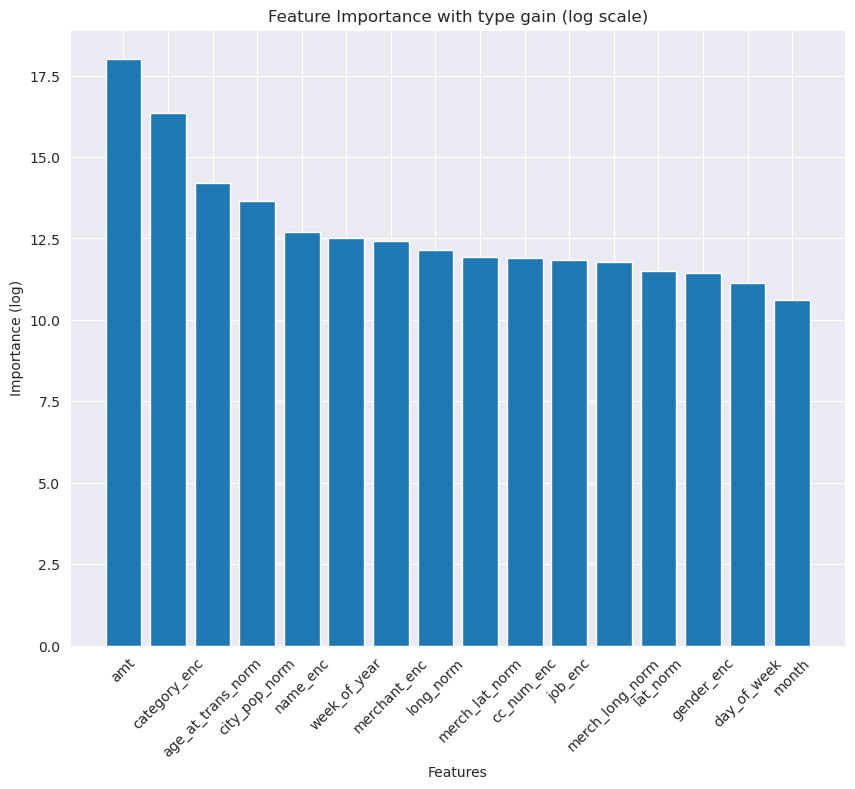

In [13]:
feature_imp = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()

feature_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_imp
})

feature_imp_df = feature_imp_df.sort_values('importance', ascending=False).reset_index(drop=True)
print(feature_imp_df)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.bar(feature_imp_df['feature'], np.log(feature_imp_df['importance']))
ax.set_title('Feature Importance with type gain (log scale)')
ax.set_xlabel('Features')
ax.set_ylabel('Importance (log)')
ax.tick_params(axis='x', labelrotation=45)

              feature  importance
0                 amt         782
1        category_enc         574
2   age_at_trans_norm         375
3       city_pop_norm         290
4        week_of_year         225
5             job_enc         190
6          cc_num_enc         177
7            name_enc         166
8            lat_norm         137
9           long_norm         136
10       merchant_enc         111
11     merch_lat_norm         110
12    merch_long_norm          95
13        day_of_week          93
14         gender_enc          76
15              month          33


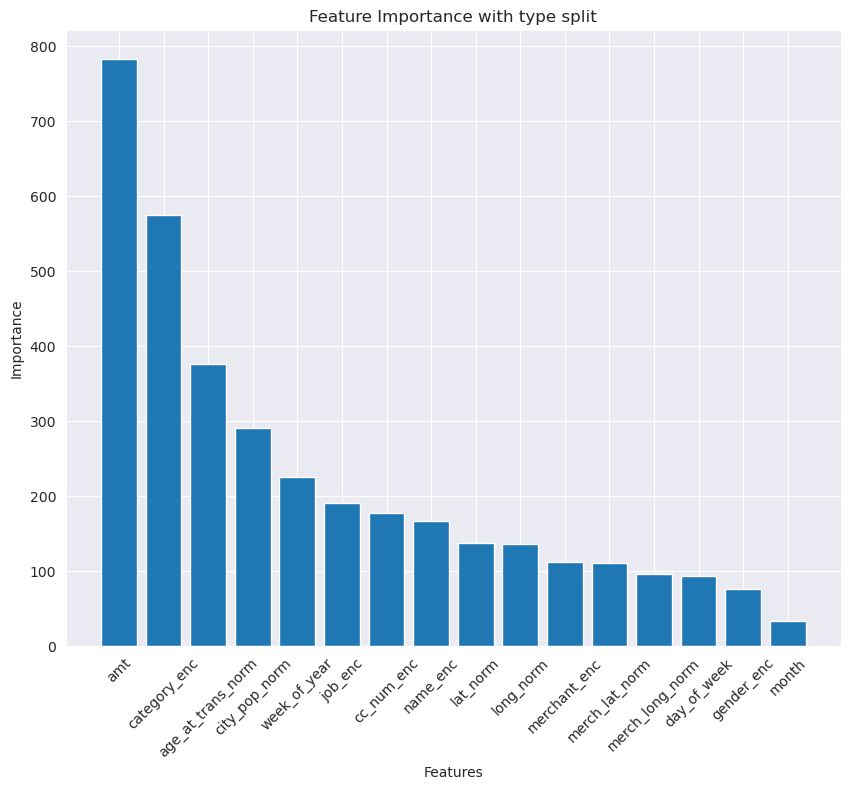

In [14]:
feature_imp = model.feature_importance(importance_type='split')
feature_names = model.feature_name()

feature_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_imp
})

feature_imp_df = feature_imp_df.sort_values('importance', ascending=False).reset_index(drop=True)
print(feature_imp_df)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.bar(feature_imp_df['feature'], feature_imp_df['importance'])
ax.set_title('Feature Importance with type split')
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.tick_params(axis='x', labelrotation=45)